# MNIST Diffusion with Custom CUDA Implementations

This notebook implements the same diffusion model but replaces Conv2d, ConvTranspose2d, and Linear layers with pure CUDA C++ implementations.

In [1]:
!pip install opencv-python ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.9 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pickle
import torch
import torchvision as tv
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.cpp_extension import load_inline

from tqdm import tqdm
from matplotlib import pyplot as plt
import cv2

## CUDA Implementation for Conv2d

In [3]:
cuda_conv2d_source = """
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void conv2d_forward_kernel(
    const float* __restrict__ input,
    const float* __restrict__ weight,
    const float* __restrict__ bias,
    float* __restrict__ output,
    int batch_size, int in_channels, int out_channels,
    int height, int width,
    int kernel_size, int stride, int padding
) {
    int out_h = (height + 2 * padding - kernel_size) / stride + 1;
    int out_w = (width + 2 * padding - kernel_size) / stride + 1;

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch_size * out_channels * out_h * out_w;

    if (idx < total) {
        int w_out = idx % out_w;
        int h_out = (idx / out_w) % out_h;
        int c_out = (idx / (out_w * out_h)) % out_channels;
        int b = idx / (out_w * out_h * out_channels);

        float sum = 0.0f;

        for (int c_in = 0; c_in < in_channels; c_in++) {
            for (int kh = 0; kh < kernel_size; kh++) {
                for (int kw = 0; kw < kernel_size; kw++) {
                    int h_in = h_out * stride - padding + kh;
                    int w_in = w_out * stride - padding + kw;

                    if (h_in >= 0 && h_in < height && w_in >= 0 && w_in < width) {
                        int input_idx = ((b * in_channels + c_in) * height + h_in) * width + w_in;
                        int weight_idx = ((c_out * in_channels + c_in) * kernel_size + kh) * kernel_size + kw;
                        sum += input[input_idx] * weight[weight_idx];
                    }
                }
            }
        }

        if (bias != nullptr) {
            sum += bias[c_out];
        }

        output[idx] = sum;
    }
}

torch::Tensor conv2d_forward(
    torch::Tensor input,
    torch::Tensor weight,
    torch::Tensor bias,
    int stride,
    int padding
) {
    int batch_size = input.size(0);
    int in_channels = input.size(1);
    int height = input.size(2);
    int width = input.size(3);

    int out_channels = weight.size(0);
    int kernel_size = weight.size(2);

    int out_h = (height + 2 * padding - kernel_size) / stride + 1;
    int out_w = (width + 2 * padding - kernel_size) / stride + 1;

    auto output = torch::zeros({batch_size, out_channels, out_h, out_w}, input.options());

    int total = batch_size * out_channels * out_h * out_w;
    int threads = 256;
    int blocks = (total + threads - 1) / threads;

    const float* bias_ptr = bias.defined() ? bias.data_ptr<float>() : nullptr;

    conv2d_forward_kernel<<<blocks, threads>>>(
        input.data_ptr<float>(),
        weight.data_ptr<float>(),
        bias_ptr,
        output.data_ptr<float>(),
        batch_size, in_channels, out_channels,
        height, width,
        kernel_size, stride, padding
    );

    return output;
}
"""

cuda_conv2d_cpp_source = """
torch::Tensor conv2d_forward(
    torch::Tensor input,
    torch::Tensor weight,
    torch::Tensor bias,
    int stride,
    int padding
);
"""

# Compile CUDA extension
conv2d_cuda = load_inline(
    name='conv2d_cuda',
    cpp_sources=cuda_conv2d_cpp_source,
    cuda_sources=cuda_conv2d_source,
    functions=['conv2d_forward'],
    verbose=True,
    extra_cuda_cflags=['-O3']
)

print("Conv2d CUDA module compiled successfully!")

W1110 15:08:12.141000 248 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1110 15:08:12.141000 248 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Conv2d CUDA module compiled successfully!


## CUDA Implementation for ConvTranspose2d

In [4]:
cuda_convtranspose2d_source = """
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void convtranspose2d_forward_kernel(
    const float* __restrict__ input,
    const float* __restrict__ weight,
    const float* __restrict__ bias,
    float* __restrict__ output,
    int batch_size, int in_channels, int out_channels,
    int in_height, int in_width,
    int kernel_size, int stride, int padding
) {
    int out_h = (in_height - 1) * stride - 2 * padding + kernel_size;
    int out_w = (in_width - 1) * stride - 2 * padding + kernel_size;

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch_size * out_channels * out_h * out_w;

    if (idx < total) {
        int w_out = idx % out_w;
        int h_out = (idx / out_w) % out_h;
        int c_out = (idx / (out_w * out_h)) % out_channels;
        int b = idx / (out_w * out_h * out_channels);

        float sum = 0.0f;

        for (int c_in = 0; c_in < in_channels; c_in++) {
            for (int kh = 0; kh < kernel_size; kh++) {
                for (int kw = 0; kw < kernel_size; kw++) {
                    int h_in = (h_out + padding - kh);
                    int w_in = (w_out + padding - kw);

                    if (h_in % stride == 0 && w_in % stride == 0) {
                        h_in /= stride;
                        w_in /= stride;

                        if (h_in >= 0 && h_in < in_height && w_in >= 0 && w_in < in_width) {
                            int input_idx = ((b * in_channels + c_in) * in_height + h_in) * in_width + w_in;
                            int weight_idx = ((c_in * out_channels + c_out) * kernel_size + kh) * kernel_size + kw;
                            sum += input[input_idx] * weight[weight_idx];
                        }
                    }
                }
            }
        }

        if (bias != nullptr) {
            sum += bias[c_out];
        }

        output[idx] = sum;
    }
}

torch::Tensor convtranspose2d_forward(
    torch::Tensor input,
    torch::Tensor weight,
    torch::Tensor bias,
    int stride,
    int padding
) {
    int batch_size = input.size(0);
    int in_channels = input.size(1);
    int in_height = input.size(2);
    int in_width = input.size(3);

    int out_channels = weight.size(1);
    int kernel_size = weight.size(2);

    int out_h = (in_height - 1) * stride - 2 * padding + kernel_size;
    int out_w = (in_width - 1) * stride - 2 * padding + kernel_size;

    auto output = torch::zeros({batch_size, out_channels, out_h, out_w}, input.options());

    int total = batch_size * out_channels * out_h * out_w;
    int threads = 256;
    int blocks = (total + threads - 1) / threads;

    const float* bias_ptr = bias.defined() ? bias.data_ptr<float>() : nullptr;

    convtranspose2d_forward_kernel<<<blocks, threads>>>(
        input.data_ptr<float>(),
        weight.data_ptr<float>(),
        bias_ptr,
        output.data_ptr<float>(),
        batch_size, in_channels, out_channels,
        in_height, in_width,
        kernel_size, stride, padding
    );

    return output;
}
"""

cuda_convtranspose2d_cpp_source = """
torch::Tensor convtranspose2d_forward(
    torch::Tensor input,
    torch::Tensor weight,
    torch::Tensor bias,
    int stride,
    int padding
);
"""

# Compile CUDA extension
convtranspose2d_cuda = load_inline(
    name='convtranspose2d_cuda',
    cpp_sources=cuda_convtranspose2d_cpp_source,
    cuda_sources=cuda_convtranspose2d_source,
    functions=['convtranspose2d_forward'],
    verbose=True,
    extra_cuda_cflags=['-O3']
)

print("ConvTranspose2d CUDA module compiled successfully!")

W1110 15:09:39.631000 248 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1110 15:09:39.631000 248 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


ConvTranspose2d CUDA module compiled successfully!


## CUDA Implementation for Linear Layer

In [5]:
cuda_linear_source = """
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void linear_forward_kernel(
    const float* __restrict__ input,
    const float* __restrict__ weight,
    const float* __restrict__ bias,
    float* __restrict__ output,
    int batch_size,
    int in_features,
    int out_features
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch_size * out_features;

    if (idx < total) {
        int b = idx / out_features;
        int o = idx % out_features;

        float sum = 0.0f;
        for (int i = 0; i < in_features; i++) {
            sum += input[b * in_features + i] * weight[o * in_features + i];
        }

        if (bias != nullptr) {
            sum += bias[o];
        }

        output[idx] = sum;
    }
}

torch::Tensor linear_forward(
    torch::Tensor input,
    torch::Tensor weight,
    torch::Tensor bias
) {
    auto input_flat = input.reshape({-1, input.size(-1)});
    int batch_size = input_flat.size(0);
    int in_features = input_flat.size(1);
    int out_features = weight.size(0);

    auto output = torch::zeros({batch_size, out_features}, input.options());

    int total = batch_size * out_features;
    int threads = 256;
    int blocks = (total + threads - 1) / threads;

    const float* bias_ptr = bias.defined() ? bias.data_ptr<float>() : nullptr;

    linear_forward_kernel<<<blocks, threads>>>(
        input_flat.data_ptr<float>(),
        weight.data_ptr<float>(),
        bias_ptr,
        output.data_ptr<float>(),
        batch_size,
        in_features,
        out_features
    );

    auto orig_shape = input.sizes().vec();
    orig_shape[orig_shape.size() - 1] = out_features;
    return output.reshape(orig_shape);
}
"""

cuda_linear_cpp_source = """
torch::Tensor linear_forward(
    torch::Tensor input,
    torch::Tensor weight,
    torch::Tensor bias
);
"""

# Compile CUDA extension
linear_cuda = load_inline(
    name='linear_cuda',
    cpp_sources=cuda_linear_cpp_source,
    cuda_sources=cuda_linear_source,
    functions=['linear_forward'],
    verbose=True,
    extra_cuda_cflags=['-O3']
)

print("Linear CUDA module compiled successfully!")

W1110 15:11:04.432000 248 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1110 15:11:04.432000 248 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Linear CUDA module compiled successfully!


## Custom Layer Wrappers

In [16]:
class Conv2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias, stride, padding):
        ctx.save_for_backward(input, weight, bias)
        ctx.stride = stride
        ctx.padding = padding
        output = conv2d_cuda.conv2d_forward(input, weight, bias, stride, padding)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Use PyTorch's native operations for backward pass
        input, weight, bias = ctx.saved_tensors
        stride = ctx.stride
        padding = ctx.padding

        # Compute gradients using PyTorch's built-in functions
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = torch.nn.grad.conv2d_input(
                input.shape, weight, grad_output, stride=(stride, stride),
                padding=(padding, padding)
            )

        if ctx.needs_input_grad[1]:
            grad_weight = torch.nn.grad.conv2d_weight(
                input, weight.shape, grad_output, stride=(stride, stride),
                padding=(padding, padding)
            )

        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(dim=(0, 2, 3))

        return grad_input, grad_weight, grad_bias, None, None


class ConvTranspose2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias, stride, padding):
        ctx.save_for_backward(input, weight, bias)
        ctx.stride = stride
        ctx.padding = padding
        output = convtranspose2d_cuda.convtranspose2d_forward(input, weight, bias, stride, padding)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Use PyTorch's native operations for backward pass
        input, weight, bias = ctx.saved_tensors
        stride = ctx.stride
        padding = ctx.padding

        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            # For transposed conv, the gradient w.r.t input uses regular convolution
            grad_input = F.conv2d(
                grad_output, weight, stride=stride, padding=padding
            )

        if ctx.needs_input_grad[1]:
            # Gradient w.r.t weight
            grad_weight = torch.nn.grad.conv2d_weight(
                grad_output, weight.shape, input, stride=(stride, stride),
                padding=(padding, padding)
            )

        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(dim=(0, 2, 3))

        return grad_input, grad_weight, grad_bias, None, None


class LinearFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias):
        ctx.save_for_backward(input, weight, bias)
        output = linear_cuda.linear_forward(input, weight, bias)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # Flatten input for gradient computation
        input_flat = input.reshape(-1, input.size(-1))
        grad_output_flat = grad_output.reshape(-1, grad_output.size(-1))

        if ctx.needs_input_grad[0]:
            grad_input = grad_output_flat.mm(weight)
            grad_input = grad_input.view(input.shape)

        if ctx.needs_input_grad[1]:
            grad_weight = grad_output_flat.t().mm(input_flat)

        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output_flat.sum(0)

        return grad_input, grad_weight, grad_bias

print("Autograd-compatible CUDA function wrappers created!")

Autograd-compatible CUDA function wrappers created!


In [17]:
class CudaConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CudaConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))

        # Initialize weights
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return Conv2dFunction.apply(x, self.weight, self.bias, self.stride, self.padding)


class CudaConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CudaConvTranspose2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(torch.randn(in_channels, out_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))

        # Initialize weights
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return ConvTranspose2dFunction.apply(x, self.weight, self.bias, self.stride, self.padding)


class CudaLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CudaLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

        # Initialize weights
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return LinearFunction.apply(x, self.weight, self.bias)

print("Custom CUDA layer wrappers created!")

Custom CUDA layer wrappers created!


## Configuration

In [18]:
# Config model
T = 300  # Max diffusion step
max_seq_length = 5
vocab_size = 27  # ' ': 0, 'a':1, ..., 'z':26
hidden_dim = 256

device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 32

print(f"Using device: {device}")

Using device: cuda:0


## Dataset Loading

In [19]:
# Download dataset
mnist_data = tv.datasets.MNIST(
    "./",
    download=True,
    transform=tv.transforms.Compose(
        [
            tv.transforms.ToTensor(),  # first, convert image to PyTorch tensor
        ]
    ),
)

train_data_loader = torch.utils.data.DataLoader(
    mnist_data, batch_size=batch_size, shuffle=True, num_workers=2
)

## Utilities

In [20]:
# Utilities
n2t_mapping = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
    10: "ten",
}

string_to_token = lambda x: [ord(i) - 96 for i in x]  # ' ': 0, 'a':1, ..., 'z':26


def convert_text_label(number_labels):
    text_labels = torch.zeros((len(number_labels), max_seq_length, vocab_size))
    for bidx, nlb in enumerate(number_labels):
        tokens = string_to_token(n2t_mapping[nlb])
        for tidx, token in enumerate(tokens):
            text_labels[bidx, tidx, token] = 1.0
    return text_labels


def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

## Model Architecture with CUDA Layers

In [21]:
# Models for noise estimation with CUDA implementations
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            CudaConv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            CudaConv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            CudaConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            CudaLinear(input_dim, emb_dim),
            nn.GELU(),
            CudaLinear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = nn.GRU(n_classes, 2 * n_feat, batch_first=True)
        self.contextembed2 = nn.GRU(n_classes, 1 * n_feat, batch_first=True)

        self.up0 = nn.Sequential(
            CudaConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            CudaConv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            CudaConv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        context_mask = -1 * (1 - context_mask)
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c)[0].view(-1, max_seq_length, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c)[0].view(-1, max_seq_length, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1.mean(1) * up1 + temb1, down2)
        esp_theta_w_context = self.up2(cemb2.mean(1) * up2 + temb2, down1)

        esp_theta_wo_context = x + t[:, None, None, None]

        out = self.out(torch.cat((esp_theta_w_context, esp_theta_wo_context), 1))
        return out

print("Model architecture defined with CUDA layers!")

Model architecture defined with CUDA layers!


## Model Initialization

In [22]:
# Noise learning - Epsilon_theta
esp_theta_model = ContextUnet(
    in_channels=1, n_feat=hidden_dim, n_classes=vocab_size
).to(device)

# Optimizer and Loss
model_params = esp_theta_model.parameters()
optimizer = torch.optim.Adam(model_params, lr=1e-4)
loss_fn = torch.nn.MSELoss()

print(f"Model has {sum(p.numel() for p in esp_theta_model.parameters())} parameters")

Model has 27024129 parameters


## Diffusion Hyperparameters

In [23]:
# Setting hyperparameters for diffusion process
beta_1 = 1e-4
beta_2 = 2e-2
beta_t = (beta_2 - beta_1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta_1
beta_t = beta_t.to(device)

alpha_t = 1 - beta_t
alphabar_t = torch.exp(torch.cumsum(torch.log(alpha_t), dim=0))

sqrtab = torch.sqrt(alphabar_t)
sqrtmab = torch.sqrt(1 - alphabar_t)

sqrt_beta_t = torch.sqrt(beta_t)
oneover_sqrta = 1 / torch.sqrt(alpha_t)
mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

## Training Loop

In [24]:
# TRAINING
EPOCHS = 1

for e in range(EPOCHS):
    print("========== EPOCH %d ==========" % e)
    total_loss = 0
    batch_idx = 0

    for imgs, lbs in tqdm(train_data_loader, desc=f"Epoch {e + 1}"):
        # Input preparation
        x_in = imgs.to(device)
        context = convert_text_label(lbs.numpy().tolist()).to(device)

        # Forward diffusion
        t = torch.randint(low=1, high=T, size=(x_in.shape[0],)).to(device)
        esp = torch.randn_like(x_in).to(device)

        x_t = sqrtab[t, None, None, None] * x_in + sqrtmab[t, None, None, None] * esp

        context_mask = torch.bernoulli(torch.zeros_like(context) + 0.1).to(device)
        esp_theta = esp_theta_model(x_t, context, t / T, context_mask)

        # Loss calculation
        loss = loss_fn(esp, esp_theta)
        total_loss += loss.cpu().item()
        if batch_idx % 100 == 0:
            print("\tLoss:", loss.item())

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_idx += 1

    print(f"Average Loss for Epoch {e}: {total_loss / batch_idx}")

========== EPOCH 0 ==========


Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

	Loss: 523.7639770507812


Epoch 1:   5%|▌         | 101/1875 [02:32<44:09,  1.49s/it]

	Loss: 3.198045253753662


Epoch 1:  11%|█         | 201/1875 [05:01<41:32,  1.49s/it]

	Loss: 1.8756165504455566


Epoch 1:  16%|█▌        | 301/1875 [07:30<39:04,  1.49s/it]

	Loss: 1.2771342992782593


Epoch 1:  21%|██▏       | 401/1875 [09:59<36:38,  1.49s/it]

	Loss: 1.0376653671264648


Epoch 1:  27%|██▋       | 501/1875 [12:28<34:08,  1.49s/it]

	Loss: 0.7384358644485474


Epoch 1:  32%|███▏      | 601/1875 [14:57<31:38,  1.49s/it]

	Loss: 0.719209611415863


Epoch 1:  37%|███▋      | 701/1875 [17:26<29:12,  1.49s/it]

	Loss: 0.5706380605697632


Epoch 1:  43%|████▎     | 801/1875 [19:55<26:42,  1.49s/it]

	Loss: 0.4739667475223541


Epoch 1:  48%|████▊     | 901/1875 [22:25<24:12,  1.49s/it]

	Loss: 0.4308319687843323


Epoch 1:  53%|█████▎    | 1001/1875 [24:54<21:42,  1.49s/it]

	Loss: 0.3682844042778015


Epoch 1:  59%|█████▊    | 1101/1875 [27:23<19:14,  1.49s/it]

	Loss: 0.3873478174209595


Epoch 1:  64%|██████▍   | 1201/1875 [29:52<16:45,  1.49s/it]

	Loss: 0.35811328887939453


Epoch 1:  69%|██████▉   | 1301/1875 [32:21<14:15,  1.49s/it]

	Loss: 0.3656570315361023


Epoch 1:  75%|███████▍  | 1401/1875 [34:50<11:46,  1.49s/it]

	Loss: 0.3156470060348511


Epoch 1:  80%|████████  | 1501/1875 [37:19<09:17,  1.49s/it]

	Loss: 0.2941274046897888


Epoch 1:  85%|████████▌ | 1601/1875 [39:48<06:48,  1.49s/it]

	Loss: 0.23767416179180145


Epoch 1:  91%|█████████ | 1701/1875 [42:17<04:19,  1.49s/it]

	Loss: 0.23279552161693573


Epoch 1:  96%|█████████▌| 1801/1875 [44:46<01:50,  1.49s/it]

	Loss: 0.19838444888591766


Epoch 1: 100%|██████████| 1875/1875 [46:37<00:00,  1.49s/it]

Average Loss for Epoch 0: 1.9466073960224788


## Save Model

In [ ]:
# Save models
torch.save(esp_theta_model.state_dict(), "contextual_model_cuda.pt")
pickle.dump(beta_t.cpu(), open("beta_t_cuda.pkl", "wb"))
print("Model saved!")

## Sampling Function

In [14]:
# SAMPLING
def sampling_imgs(list_numbers, return_steps=[], mode="ddpm"):
    x_T = torch.randn(len(list_numbers), 1, 28, 28).to(device)
    context = convert_text_label(list_numbers).to(device)
    context_mask = torch.zeros_like(context).to(device)

    x_t = x_T
    if len(return_steps) > 0:
        reverse_steps = []

    # Reverse diffusion
    for t in tqdm(range(T, 0, -1)):
        if t in return_steps:
            reverse_steps.append(x_t.detach().cpu().numpy())

        norm_t = torch.tensor([t / T]).repeat(len(list_numbers)).to(device)
        esp_theta = esp_theta_model(x_t, context, norm_t, context_mask)

        if mode == "ddpm":  # Probabilistic
            sigma = (
                torch.sqrt((1 - alphabar_t[t - 1]) / (1 - alphabar_t[t]))
                * sqrt_beta_t[t]
            )
            z = torch.randn(len(list_numbers), 1, 28, 28).to(device) if t > 1 else 0

            x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * mab_over_sqrtmab[t]) + sigma * z
            )

        elif mode == "ddim":  # Deterministic
            sigma = 1e-3
            z = torch.randn(len(list_numbers), 1, 28, 28).to(device) if t > 1 else 0
            x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * sqrtmab[t])
                + esp_theta * torch.sqrt(1 - alphabar_t[t - 1] - sigma**2)
                + sigma * z
            )

    if len(return_steps) > 0:
        reverse_steps.append(x_t.detach().cpu().numpy())
        return reverse_steps

    return x_t.detach().cpu().numpy()

## Testing with DDIM

100%|██████████| 300/300 [02:11<00:00,  2.29it/s]


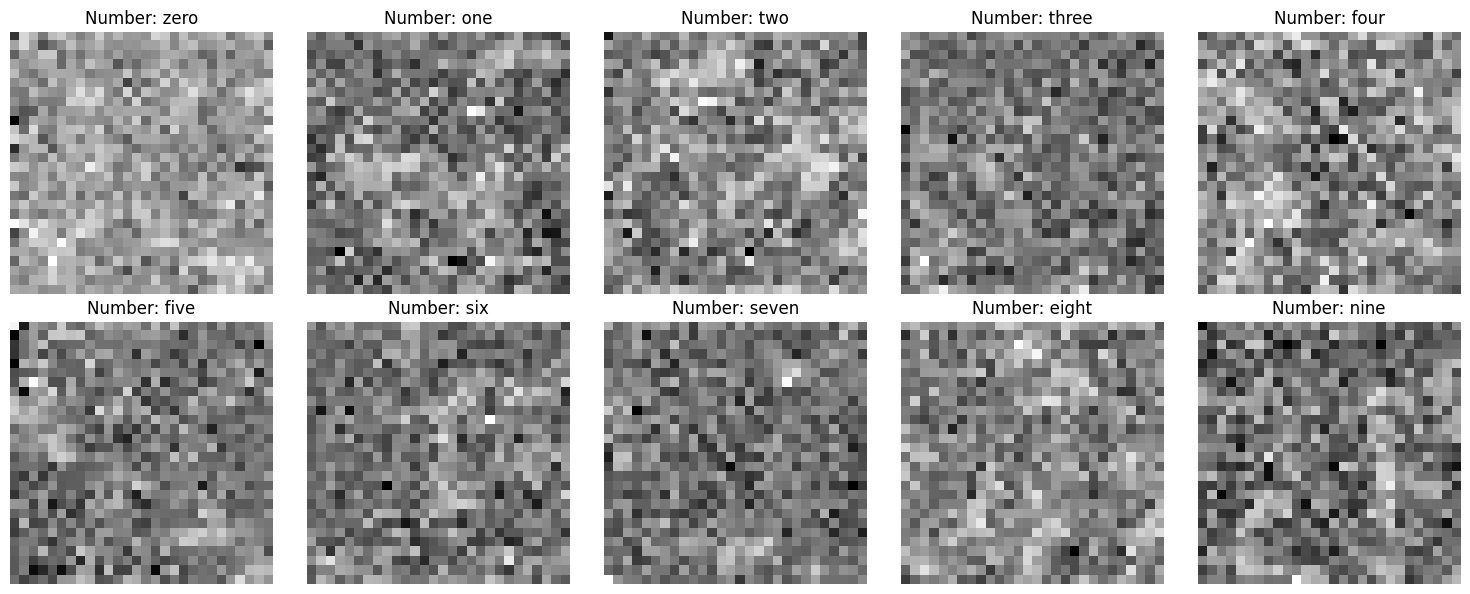

In [25]:
# Run testing DDIM
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
with torch.no_grad():
    sampled_imgs = sampling_imgs(test_numbers, mode="ddim")

# Visualize testing results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx in range(len(test_numbers)):
    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"Number: {n2t_mapping[test_numbers[idx]]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Testing with DDPM

100%|██████████| 300/300 [02:11<00:00,  2.29it/s]


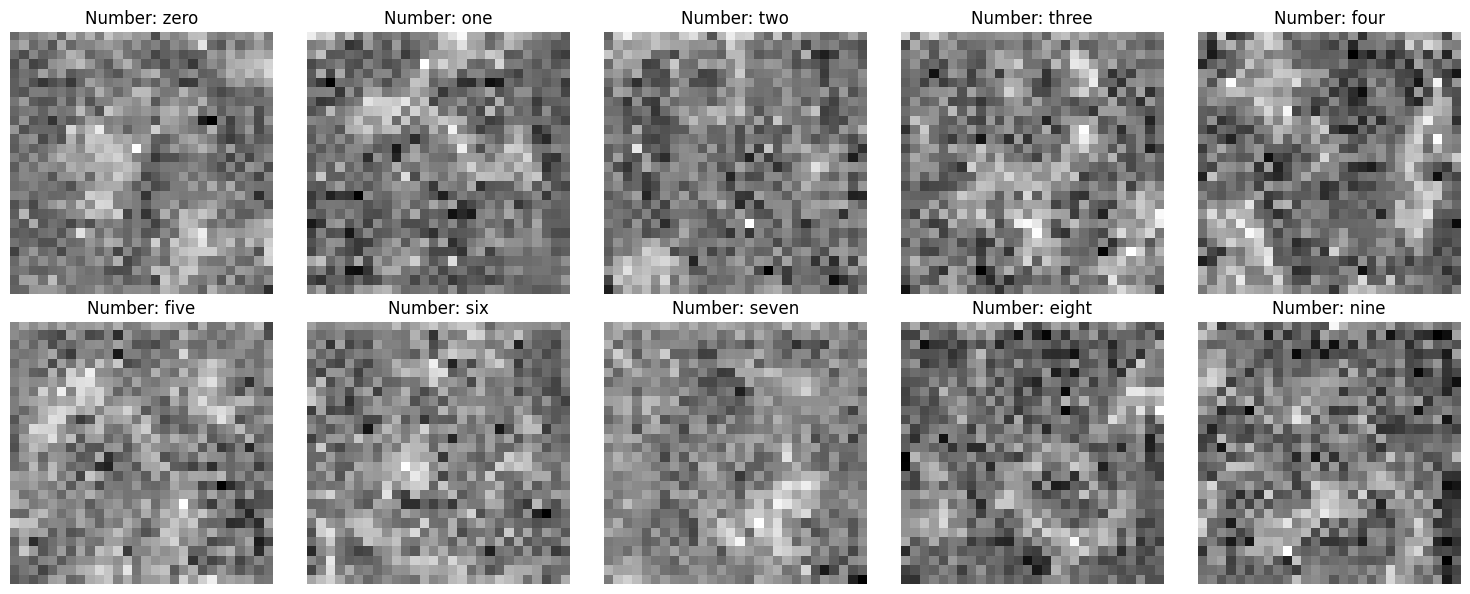

In [26]:
# Run testing DDPM
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
with torch.no_grad():
    sampled_imgs = sampling_imgs(test_numbers, mode="ddpm")

# Visualize testing results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx in range(len(test_numbers)):
    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"Number: {n2t_mapping[test_numbers[idx]]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Visualize Diffusion Process

100%|██████████| 300/300 [01:06<00:00,  4.49it/s]




Numbers: ['zero', 'one', 'two', 'three', 'four']


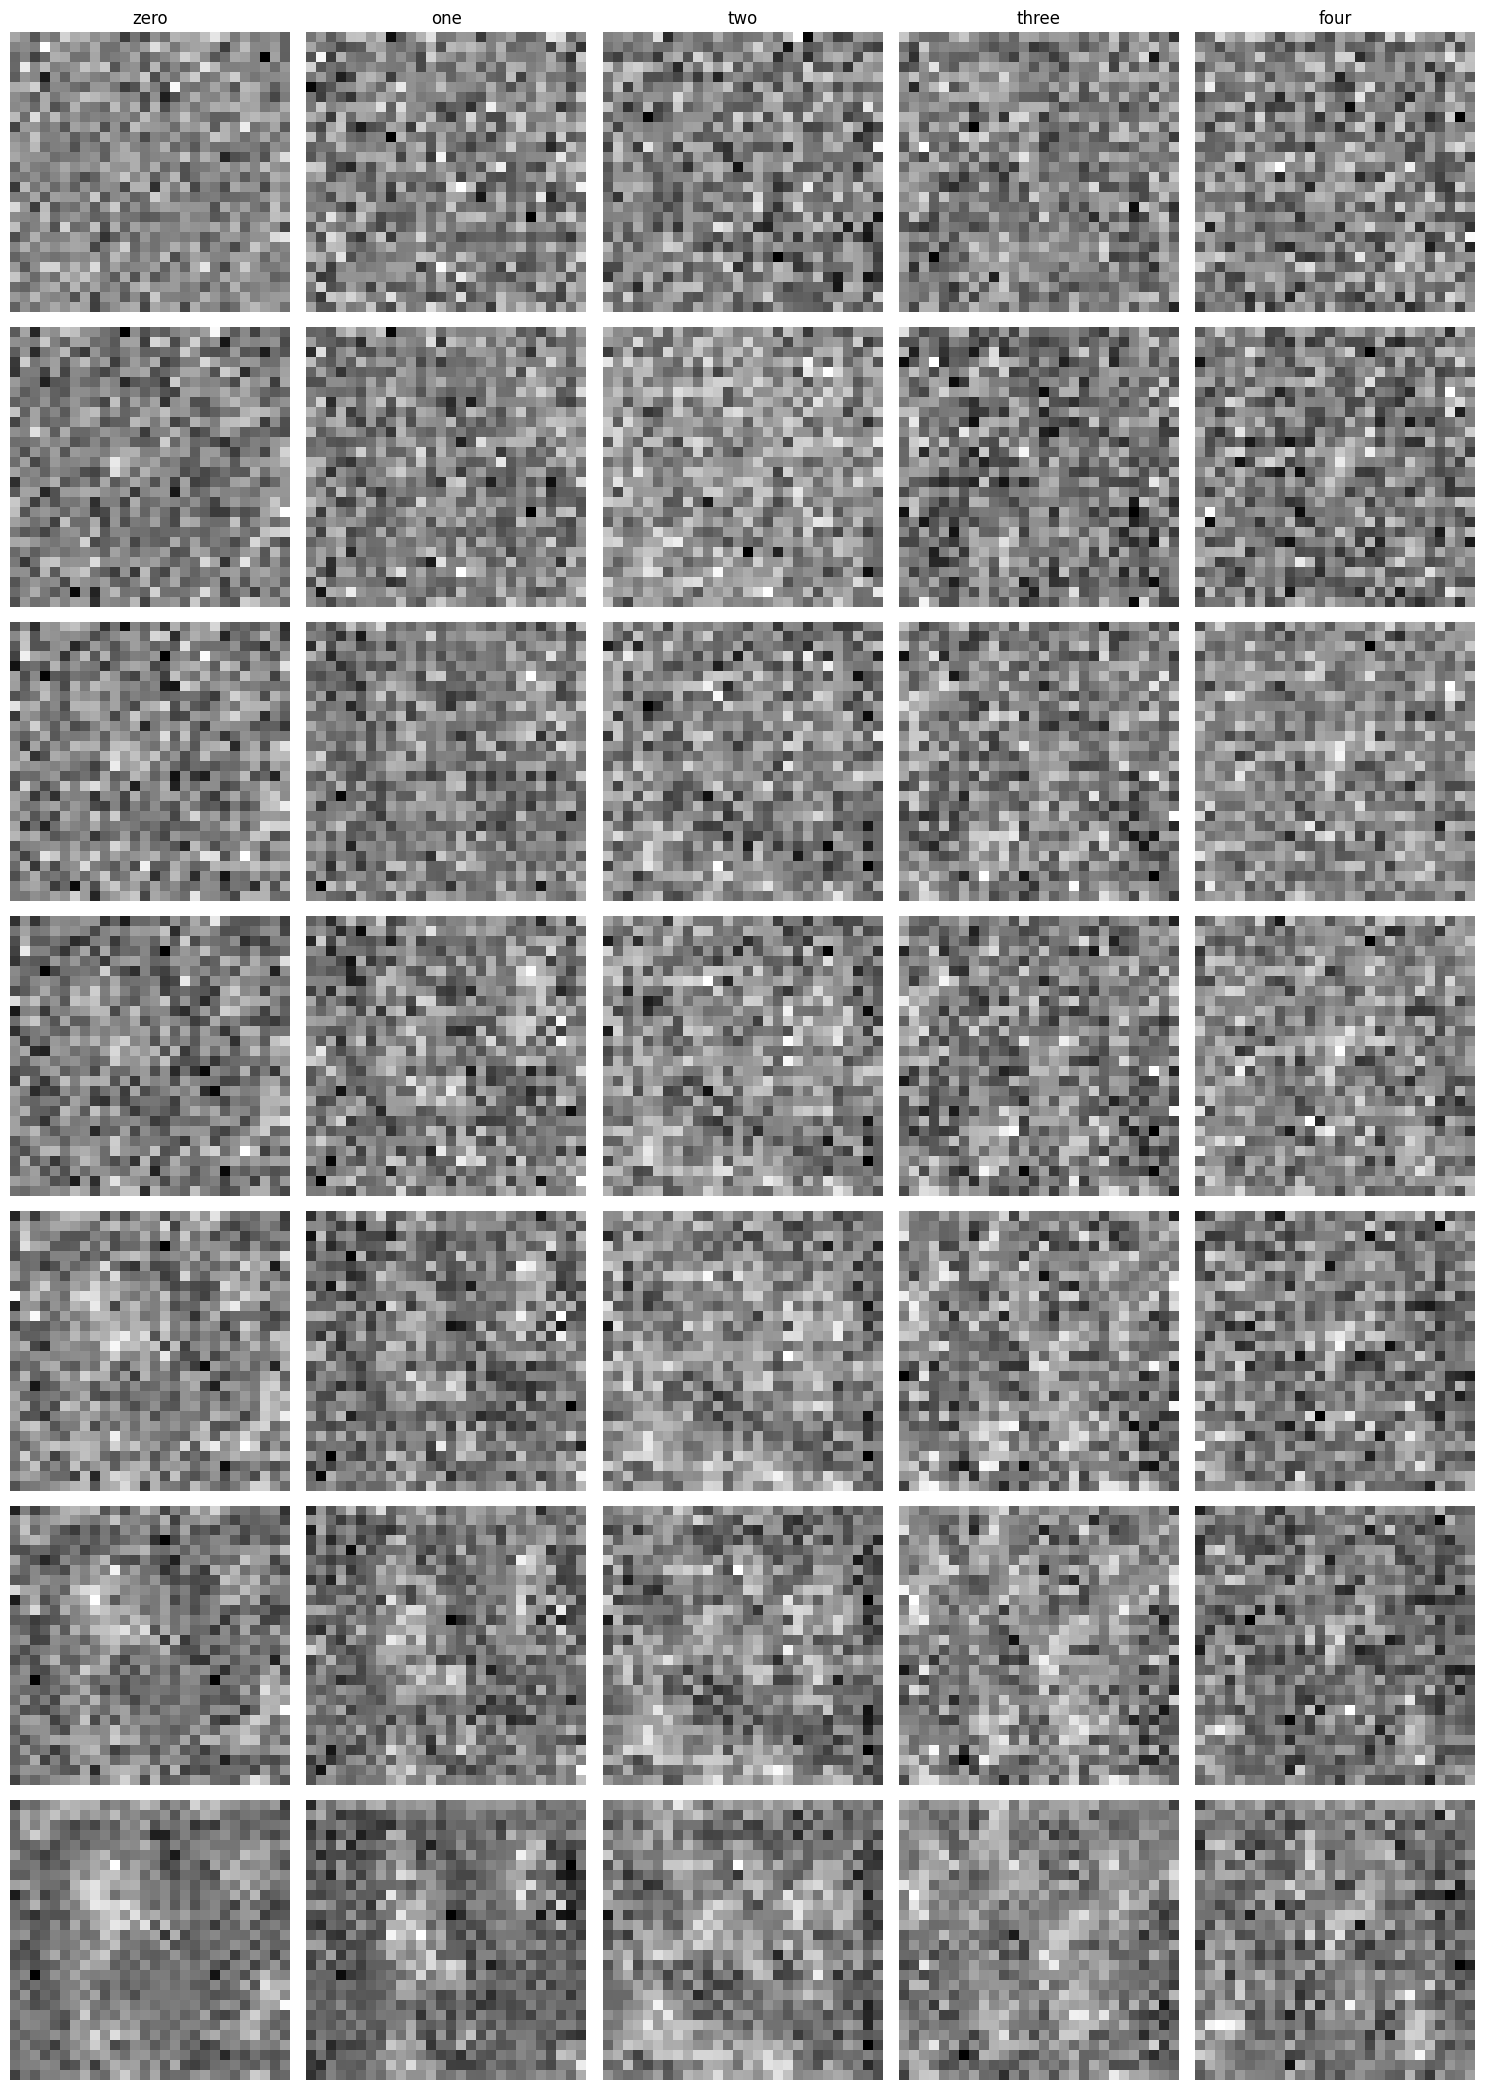

In [27]:
# Visualize reverse diffusion steps
test_numbers = [0, 1, 2, 3, 4]
steps = list(range(T, -1, -50))

with torch.no_grad():
    reverse_steps = sampling_imgs(test_numbers, return_steps=steps)

print("\n=========================\n")
print("Numbers:", [n2t_mapping[x] for x in test_numbers])

fig, axes = plt.subplots(len(steps), len(test_numbers), figsize=(15, 3 * len(steps)))

for sidx, step in enumerate(steps):
    for idx in range(len(test_numbers)):
        max_v = np.max(reverse_steps[sidx][idx][0])
        min_v = np.min(reverse_steps[sidx][idx][0])
        img = (reverse_steps[sidx][idx][0] - min_v) / (max_v - min_v)

        axes[sidx, idx].imshow(img, cmap='gray')
        if idx == 0:
            axes[sidx, idx].set_ylabel(f'Step {step}', fontsize=12)
        if sidx == 0:
            axes[sidx, idx].set_title(n2t_mapping[test_numbers[idx]], fontsize=12)
        axes[sidx, idx].axis('off')

plt.tight_layout()
plt.show()